In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from PIL import Image
import random
import pandas as pd
import glob

In [2]:
DATASET_PATH = "/Users/jiehyun/kaggle/"
IMAGE_DATASET_PATH = DATASET_PATH + "input/hubmap-organ-segmentation/train_images"
MASK_DATASET_PATH = DATASET_PATH + "input/hubmap-organ-segmentation/binary_masks"
TRAIN_CSV = DATASET_PATH + "input/hubmap-organ-segmentation/train.csv"
train_df = pd.read_csv(TRAIN_CSV)
TOTAL_NUM_DATA = 351
OUTPUT_FOLDER = "/Users/jiehyun/kaggle/output/"
IMG_NPY_512 = OUTPUT_FOLDER + 'img_npy_512'
MASK_NPY_512 = OUTPUT_FOLDER + 'mask_npy_512'

In [5]:
loadedimages = []
loadedmasks = []

for i in range(len(train_df['id'])):
    idx = random.randint(0, len(train_df) - 1)
    img_id = train_df['id'][idx]
    loadedimages += [np.load(IMG_NPY_512 + f'/{img_id}.npy', allow_pickle=True).copy()]
    loadedmasks += [np.load(MASK_NPY_512 + f'/{img_id}.npy', allow_pickle=True).copy()]

imgs = np.asarray(loadedimages)
masks = np.asarray(loadedmasks)

In [6]:
imgs.shape

(351, 512, 512, 3)

In [7]:
masks.shape

(351, 512, 512)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


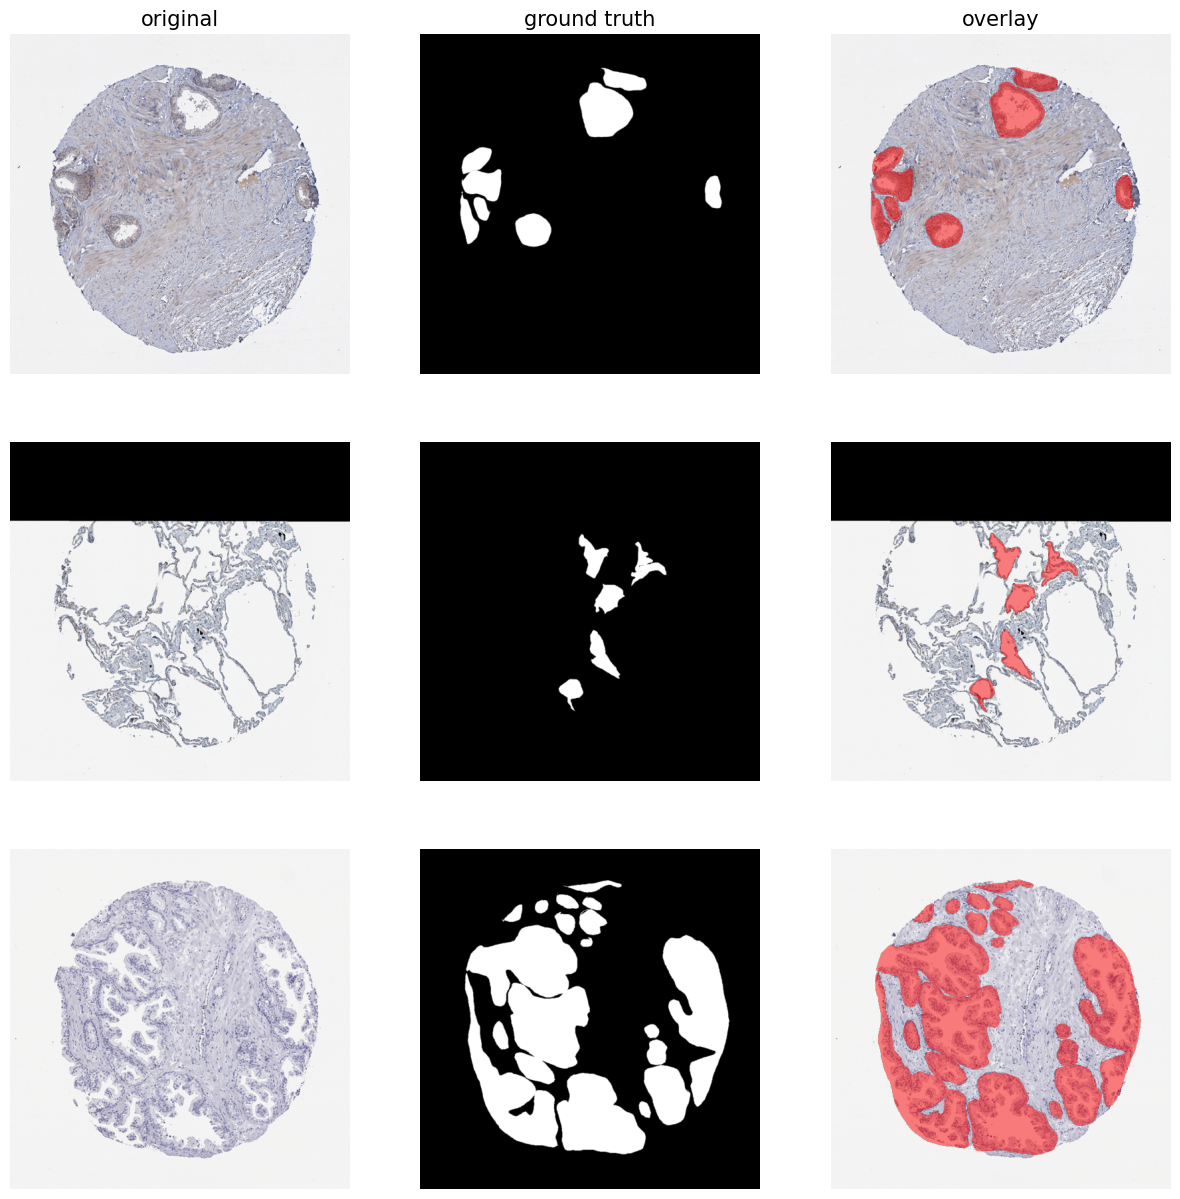

In [8]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs, mask_imgs=masks, nm_img_to_plot=3, figsize=5)

In [9]:
print(imgs.max(), masks.max())

255 255


In [10]:
x = np.asarray(imgs,dtype=np.float32)/255
y = np.asarray(masks,dtype=np.float32)/255

In [11]:
print(x.max(), y.max())

1.0 1.0


In [12]:
print(x.shape, y.shape)

(351, 512, 512, 3) (351, 512, 512)


In [13]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(351, 512, 512, 3) (351, 512, 512, 1)


In [14]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.145, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (300, 512, 512, 3)
y_train:  (300, 512, 512, 1)
x_val:  (51, 512, 512, 3)
y_val:  (51, 512, 512, 1)


In [15]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

In [16]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)

(2, 512, 512, 3) (2, 512, 512, 1)


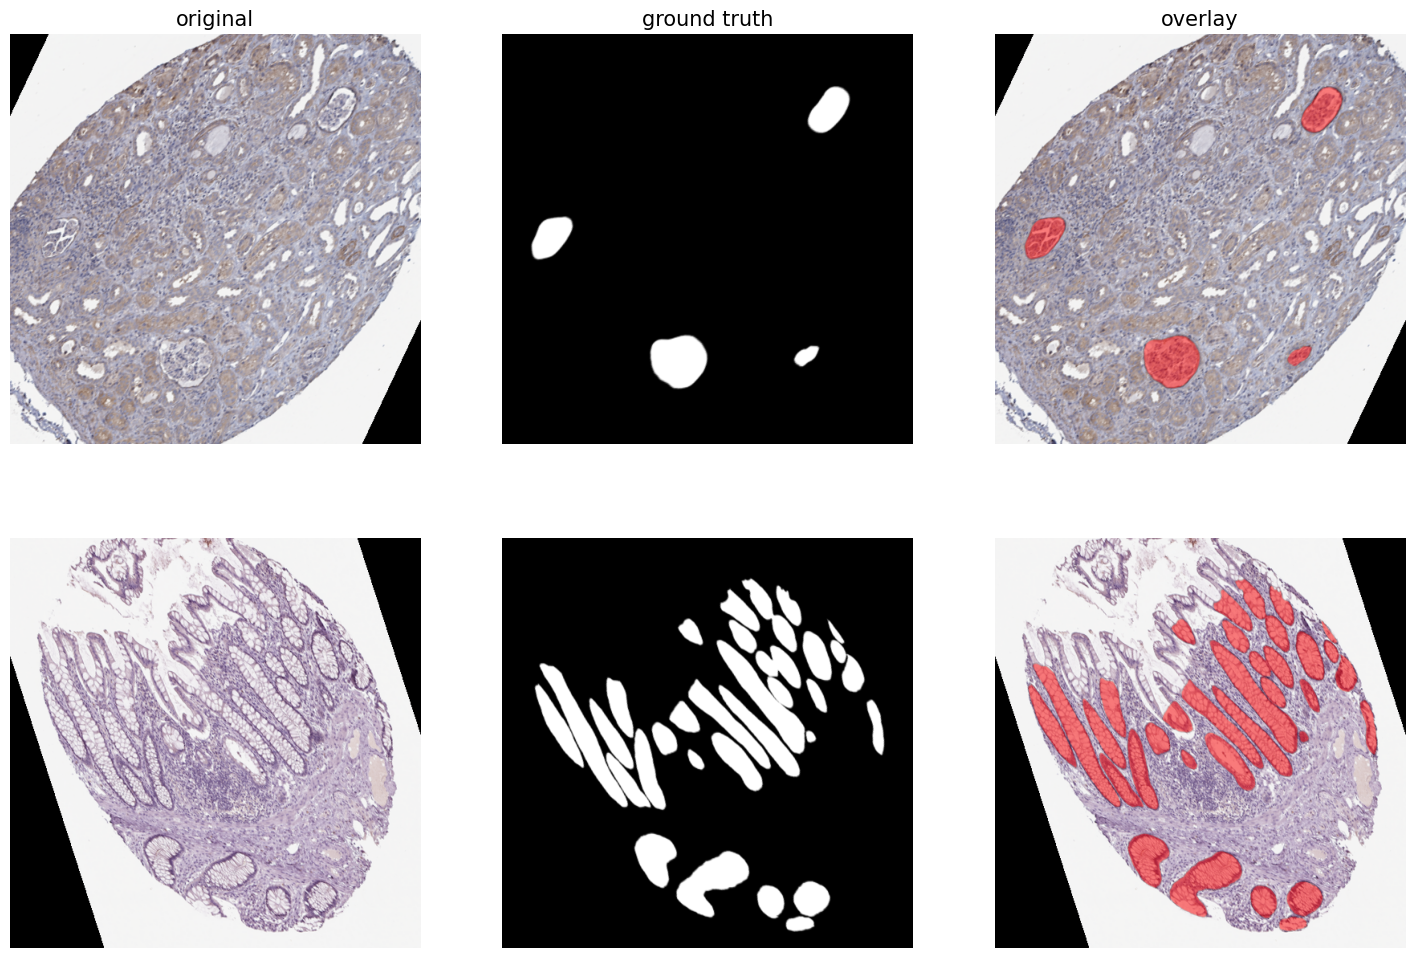

In [17]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [18]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=5
)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
from keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v3.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [21]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [22]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=50,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Epoch 1/50


/var/folders/w2/kjqd2k2x70z1qwx2jy2y7j580000gn/T/ipykernel_71007/655246040.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(
2022-11-05 02:42:39.350165: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


100/100 [==============================] - ETA: 0s - loss: 0.5730 - iou: 0.1030 - iou_thresholded: 0.1392
Epoch 1: val_loss improved from inf to 0.81578, saving model to segm_model_v3.h5
100/100 [==============================] - 451s 5s/step - loss: 0.5730 - iou: 0.1030 - iou_thresholded: 0.1392 - val_loss: 0.8158 - val_iou: 0.0904 - val_iou_thresholded: 0.0787
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.3855 - iou: 0.0999 - iou_thresholded: 0.0239
Epoch 2: val_loss improved from 0.81578 to 0.41926, saving model to segm_model_v3.h5
100/100 [==============================] - 458s 5s/step - loss: 0.3855 - iou: 0.0999 - iou_thresholded: 0.0239 - val_loss: 0.4193 - val_iou: 0.0859 - val_iou_thresholded: 0.0307
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.3016 - iou: 0.0873 - iou_thresholded: 0.0024
Epoch 3: val_loss improved from 0.41926 to 0.29202, saving model to segm_model_v3.h5
100/100 [==============================] - 466s 5s/st

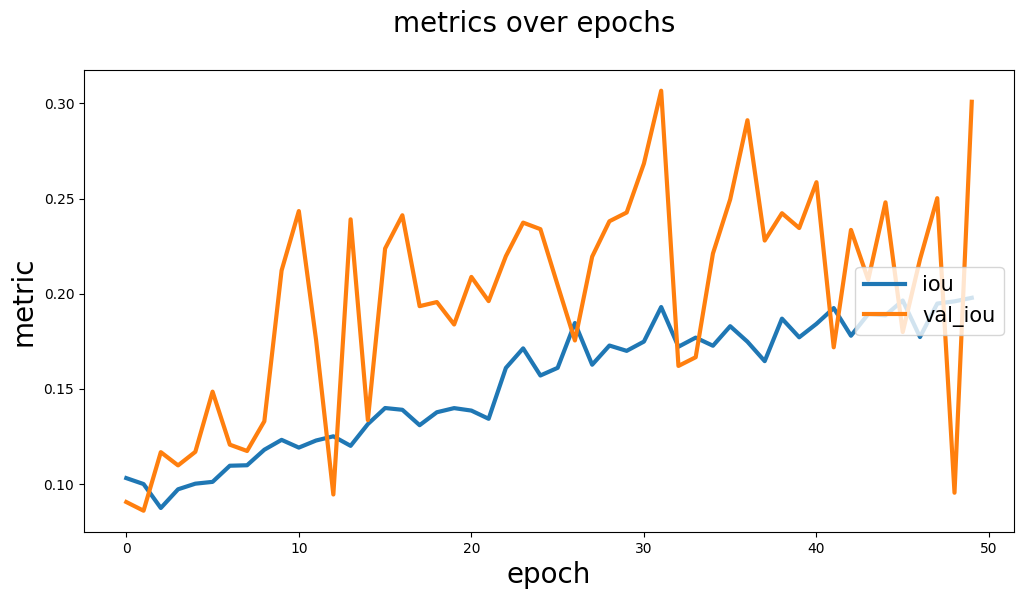

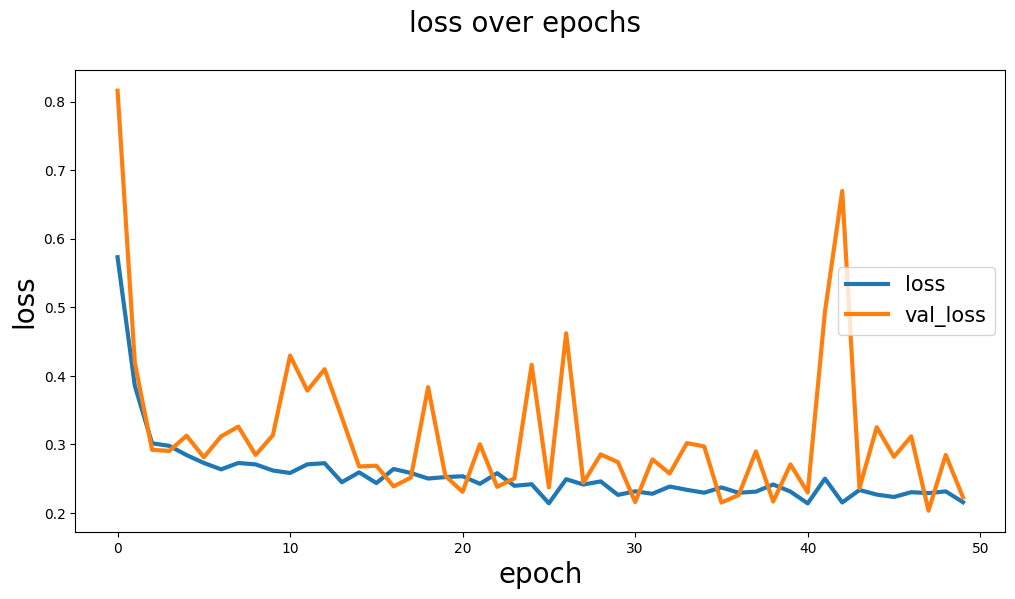

In [23]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [24]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

2/2 [==============================] - 29s 10s/step


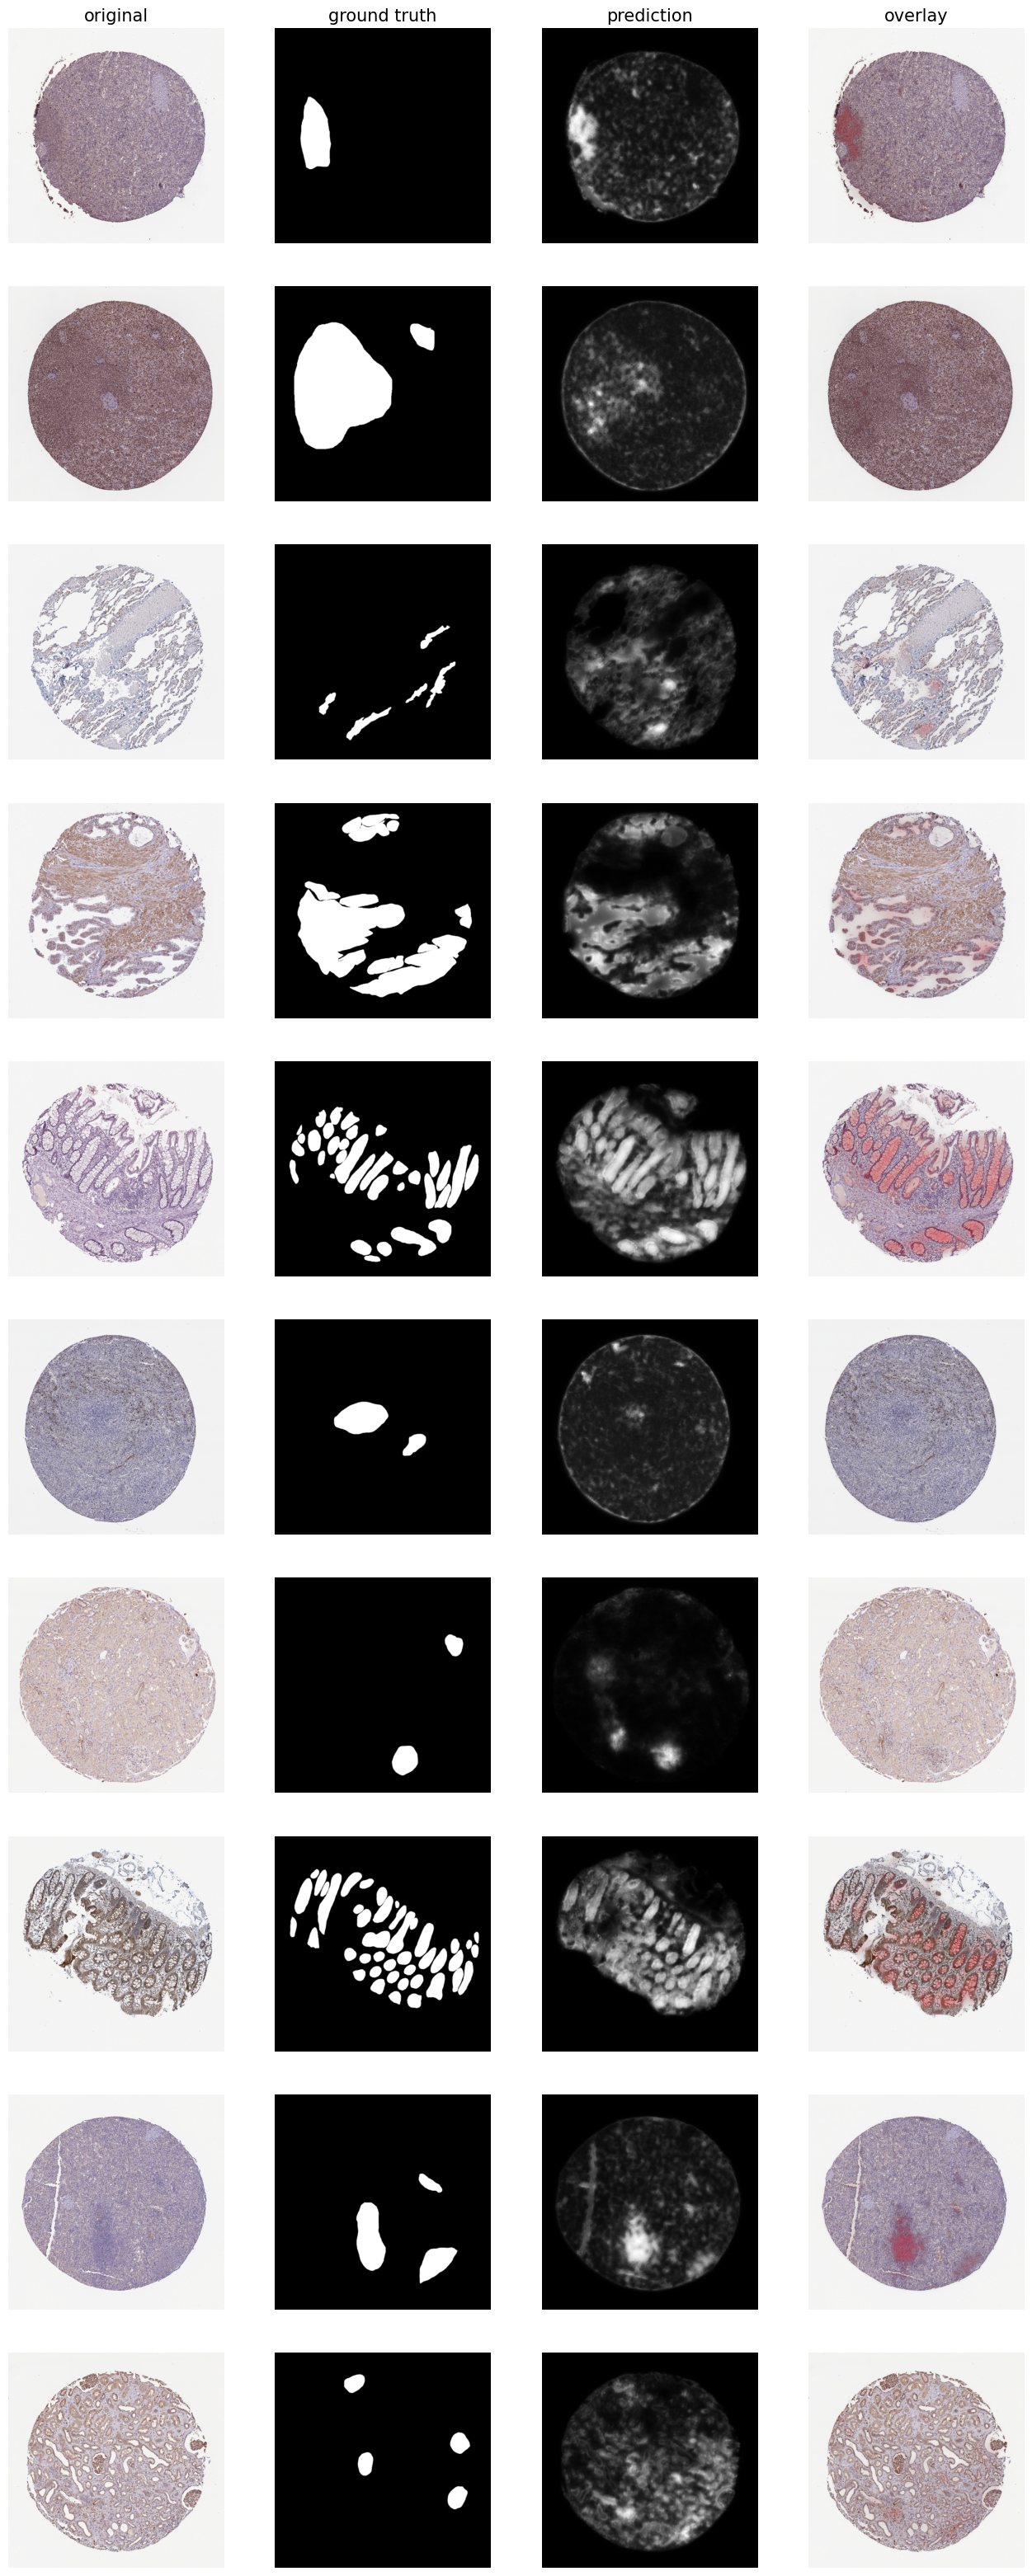

In [25]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [210]:
a = y_pred
a_binary = np.zeros(a.shape, dtype=np.bool)
a_binary[a > 0.7] = True

/var/folders/w2/kjqd2k2x70z1qwx2jy2y7j580000gn/T/ipykernel_71007/720167425.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_binary = np.zeros(a.shape, dtype=np.bool)


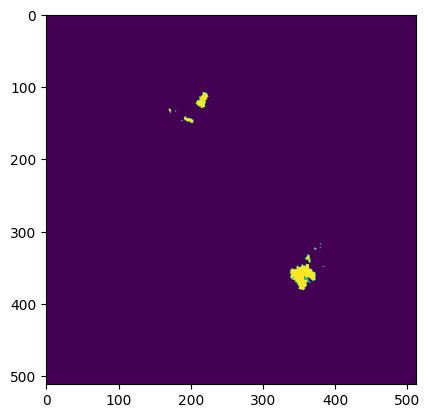

In [228]:
plt.imshow(a_binary[50])

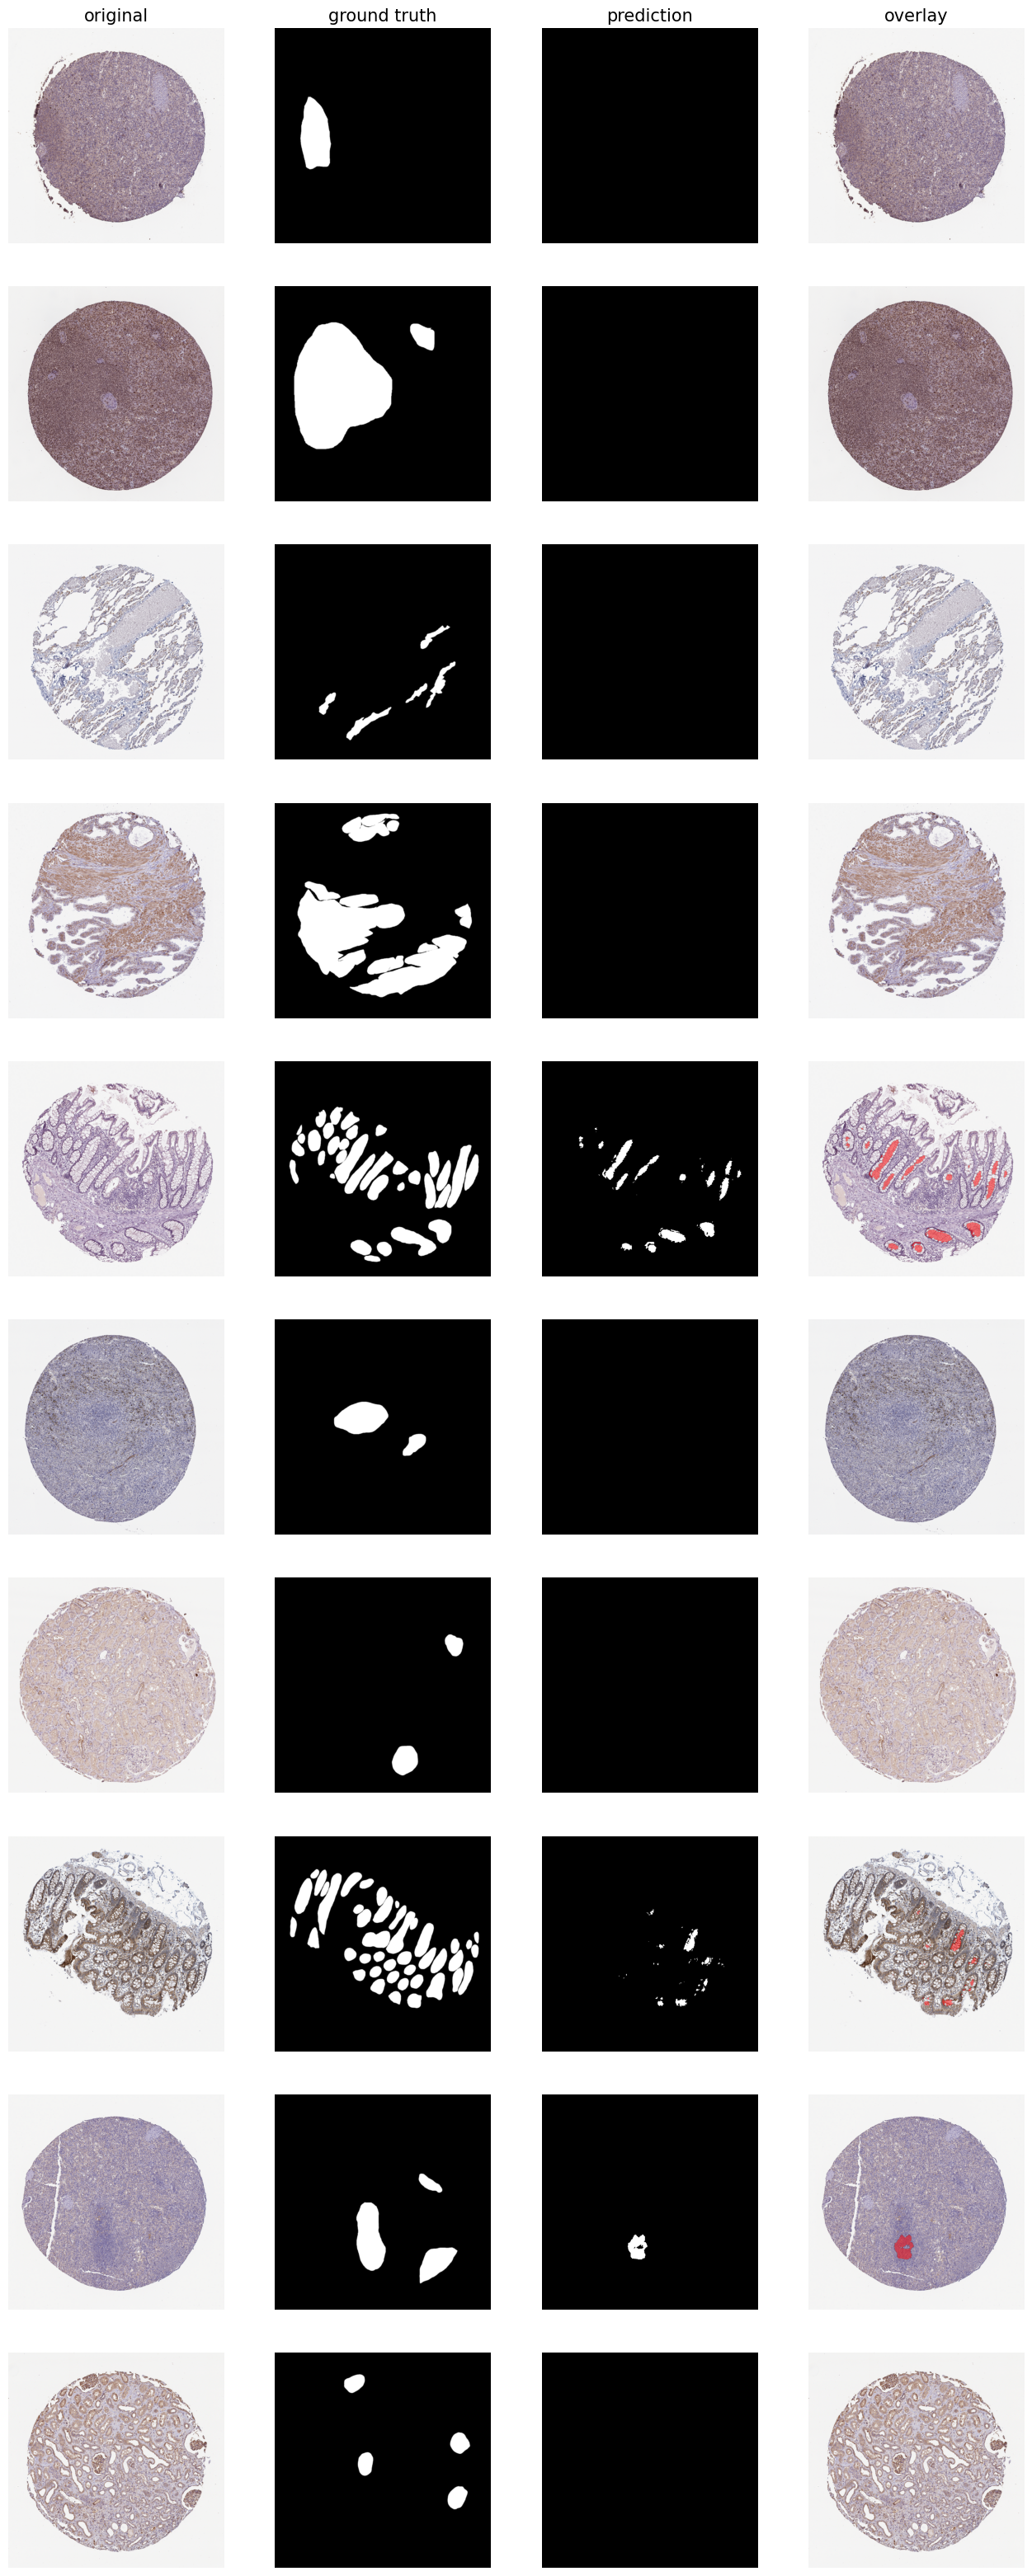

In [234]:
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=a_binary, nm_img_to_plot=10)

In [81]:
import cv2

In [155]:
im = np.array(y_pred[0] * 255, dtype = np.uint8)

In [156]:
ret,thresh1 = cv2.threshold(im,127,255,cv2.THRESH_BINARY)

In [157]:
thresh1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [160]:
print(thresh1.max(), thresh1.min())

255 0


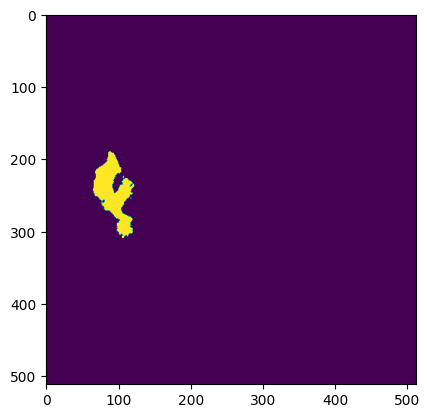

In [158]:
plt.imshow(thresh1)

In [180]:
for i in range(len(y_pred)):
    img = np.array(y_pred[i] * 255, dtype = np.uint8)
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    #cv2.imwrite('/Users/jiehyun/kaggle/output/pred_binary/' + str(i) + '.png', thresh)

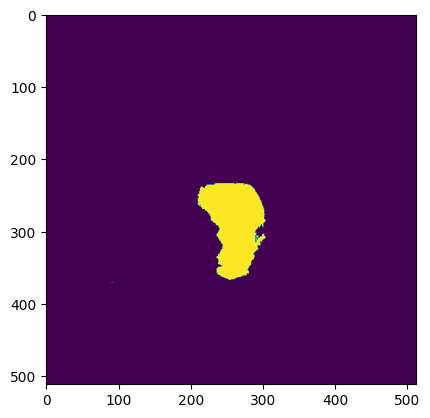

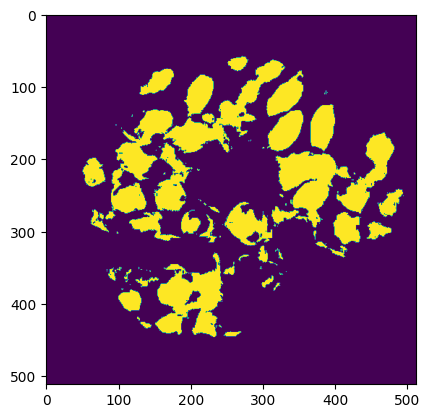

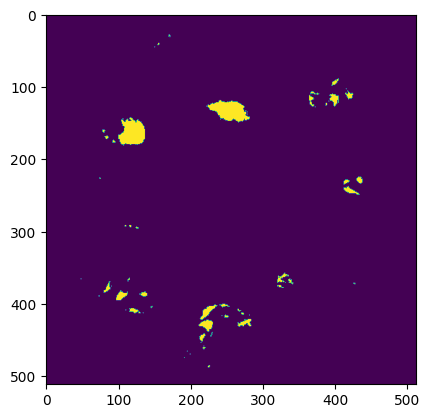

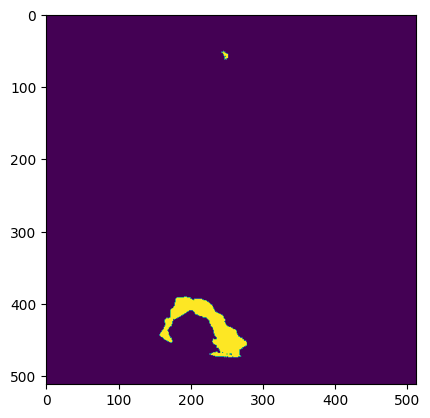

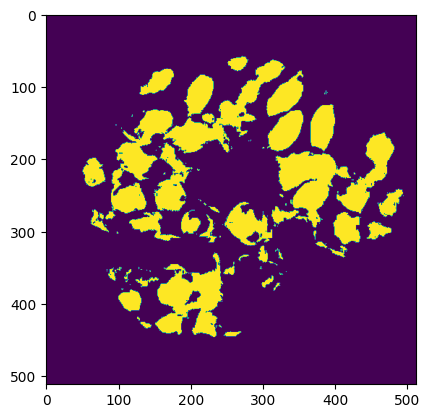

In [207]:
for i in range(5):
    idx = random.randint(0, 50)
    img = Image.open('/Users/jiehyun/kaggle/output/pred_binary' + f'/{idx}.png')
    plt.imshow(img)
    plt.show()